<a href="https://colab.research.google.com/github/bbutka/CEC220/blob/main/state_diagram_with_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the number of state variables: 2
Enter the number of input variables: 1
Enter the number of output variables: 1


Button(description='Generate State Diagram', style=ButtonStyle())

S1 | S0 | D0 | Next S1 | Next S0 | F0
-------------------------------------
   0 |    0 |    0 |    0 |    1 |    0
   0 |    0 |    1 |    0 |    0 |    0
   0 |    1 |    0 |    1 |    0 |    0
   0 |    1 |    1 |    0 |    0 |    0
   1 |    0 |    0 |    1 |    1 |    1
   1 |    0 |    1 |    0 |    0 |    0
   1 |    1 |    0 |    1 |    1 |    1
   1 |    1 |    1 |    0 |    0 |    0


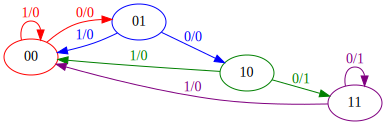

Next_S0 = (S0 & ~D0) | (S1 & ~D0)
Next_S1 = (S1 & ~D0) | (~D0 & ~S0)
F0 = S1 & ~D0


In [15]:
import graphviz
import sympy as sp
from sympy.logic.boolalg import SOPform
import ipywidgets as widgets
from ipywidgets import Layout, HBox, VBox, HTML, RadioButtons
from IPython.display import display

def generate_state_transition_table(state_vars, input_vars, output_vars):
    """Generate input widgets for the state transition table."""
    num_states = 2 ** state_vars
    num_inputs = 2 ** input_vars if input_vars > 0 else 1
    rows = num_states * num_inputs
    table_input = []
    headers = [f'S{i}' for i in range(state_vars-1, -1, -1)] + [f'D{i}' for i in range(input_vars-1, -1, -1)] + [f'Next S{i}' for i in range(state_vars-1, -1, -1)] + [f'F{i}' for i in range(output_vars-1, -1, -1)]

    style = HTML(
        "<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box"
        " label{margin:5px !important;width: 50px !important;}</style>",
        layout=Layout(display="none"),
    )

    for i in range(rows):
        row_widgets = []
        state = i // num_inputs
        inp = i % num_inputs
        state_bits = f"{state:0{state_vars}b}"
        input_bits = f"{inp:0{input_vars}b}" if input_vars > 0 else ""

        for bit in state_bits + input_bits:
            row_widgets.append(widgets.Label(value=bit, layout=Layout(width='30px', text_align='center')))

        for j in range(state_vars):
            radio_buttons = RadioButtons(options=['1', '0', 'X'], value='0', layout=Layout(display='flex', flex_direction='row'))
            row_widgets.append(HBox([radio_buttons, style]))

        for j in range(output_vars):
            radio_buttons = RadioButtons(options=['1', '0', 'X'], value='0', layout=Layout(display='flex', flex_direction='row'))
            row_widgets.append(HBox([radio_buttons, style]))

        table_input.append(row_widgets)
    return table_input, headers

def display_state_transition_table(table_input, headers):
    """Display the state transition table input widgets."""
    header_widgets = [widgets.Label(value=header, layout=Layout(width='30px', text_align='center')) for header in headers]
    display(HBox(header_widgets))

    for row in table_input:
        display(HBox(row, layout=Layout(margin='0')))

def parse_state_transition_table_input(table_input, state_vars, input_vars, output_vars):
    """Parse the user input from the state transition table."""
    transition_table = []
    dont_cares = []
    num_states = 2 ** state_vars
    num_inputs = 2 ** input_vars if input_vars > 0 else 1
    for row in table_input:
        state_input = [int(row[i].value) for i in range(state_vars)]
        inputs = [int(row[state_vars + i].value) for i in range(input_vars)] if input_vars > 0 else []
        next_state = [row[state_vars + input_vars + i].children[0].value.strip() for i in range(state_vars)]
        outputs = [row[state_vars + input_vars + state_vars + i].children[0].value.strip() for i in range(output_vars)]
        if not all(ns == 'X' for ns in next_state):
            transition_table.append(state_input + inputs + next_state + outputs)
        else:
            dont_cares.append(state_input + inputs + next_state + outputs)
    return transition_table, dont_cares

def print_transition_table(transition_table, state_vars, input_vars, output_vars):
    """Print the transition table."""
    headers = [f'S{i}' for i in range(state_vars-1, -1, -1)] + [f'D{i}' for i in range(input_vars-1, -1, -1)] + [f'Next S{i}' for i in range(state_vars-1, -1, -1)] + [f'F{i}' for i in range(output_vars-1, -1, -1)]
    header_str = " | ".join(headers)
    print(header_str)
    print("-" * len(header_str))
    for row in transition_table:
        row_str = " | ".join(f"{x:>4}" for x in row)
        print(row_str)

def create_state_machine(transition_table, state_vars, input_vars, output_vars):
    """Create and display the state machine diagram based on the transition table."""
    fsm = graphviz.Digraph(format='png')
    fsm.attr(rankdir='LR', size='8,5')

    state_colors = ["red", "blue", "green", "purple", "orange", "brown", "pink", "black"]
    state_color_map = {}

    # Filter out states with all next states as 'X'
    valid_states = {tuple(row[:state_vars]) for row in transition_table}
    valid_states = sorted(valid_states, key=lambda s: int(''.join(map(str, s)), 2))

    # Assign colors to valid states
    for i, state in enumerate(valid_states):
        state_color_map[state] = state_colors[i % len(state_colors)]

    # Add states to the diagram
    for state in valid_states:
        state_str = ''.join(map(str, state))
        fsm.node(state_str, state_str, color=state_color_map[state])

    # Add transitions to the diagram
    for row in transition_table:
        current_state = tuple(row[:state_vars])
        input_bits = ''.join(map(str, row[state_vars:state_vars + input_vars])) if input_vars > 0 else ''
        next_state = tuple(row[state_vars + input_vars:state_vars + input_vars + state_vars])
        output_bits = ''.join(map(str, row[state_vars + input_vars + state_vars:state_vars + input_vars + state_vars + output_vars]))
        next_state_str = ''.join(map(str, next_state))
        current_state_str = ''.join(map(str, current_state))
        color = state_color_map[current_state]
        fsm.edge(current_state_str, next_state_str, label=f"{input_bits}/{output_bits}", color=color, fontcolor=color)

    display(fsm)

def generate_logic_expressions(transition_table, dont_cares, state_vars, input_vars, output_vars):
    """Generate and display logic expressions for next states and outputs using SOPform."""
    state_vars_list = [sp.symbols(f'S{i}') for i in range(state_vars-1, -1, -1)]
    input_vars_list = [sp.symbols(f'D{i}') for i in range(input_vars-1, -1, -1)]

    expressions = {}

    for i in range(state_vars):
        next_state_var = sp.symbols(f'Next_S{i}')
        minterms = []
        dc_terms = []
        for row in transition_table:
            if row[state_vars + input_vars + i] == '1':
                minterms.append(row[:state_vars + input_vars])
        for row in dont_cares:
            dc_terms.append(row[:state_vars + input_vars])
        if minterms:
            expr = SOPform(state_vars_list + input_vars_list, minterms, dc_terms)
            expressions[next_state_var] = expr

    for i in range(output_vars):
        output_var = sp.symbols(f'F{i}')
        minterms = []
        dc_terms = []
        for row in transition_table:
            if row[state_vars + input_vars + state_vars + i] == '1':
                minterms.append(row[:state_vars + input_vars])
        for row in dont_cares:
            dc_terms.append(row[:state_vars + input_vars])
        if minterms:
            expr = SOPform(state_vars_list + input_vars_list, minterms, dc_terms)
            expressions[output_var] = expr

    for var, expr in expressions.items():
        print(f"{var} = {expr}")

# Function to ask for user input and create the state transition table
def create_state_transition_table():
    state_vars = int(input("Enter the number of state variables: "))
    input_vars = int(input("Enter the number of input variables: "))
    output_vars = int(input("Enter the number of output variables: "))

    table_input, headers = generate_state_transition_table(state_vars, input_vars, output_vars)
    display_state_transition_table(table_input, headers)

    def on_button_click(b):
        transition_table, dont_cares = parse_state_transition_table_input(table_input, state_vars, input_vars, output_vars)
        print_transition_table(transition_table, state_vars, input_vars, output_vars)
        create_state_machine(transition_table, state_vars, input_vars, output_vars)
        generate_logic_expressions(transition_table, dont_cares, state_vars, input_vars, output_vars)

    button = widgets.Button(description="Generate State Diagram")
    button.on_click(on_button_click)
    display(button)

# Run the function to create the state transition table
create_state_transition_table()













